## ML Forecasting next 1 month

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, jaccard_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from plot_metric.functions import BinaryClassification
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import shap
from scipy.stats import norm
from pandas.plotting import table
from sklearn.metrics import (balanced_accuracy_score, accuracy_score, f1_score, precision_score,recall_score, average_precision_score, jaccard_score)
import warnings
warnings.filterwarnings('ignore')

In [2]:
target = 'onset_1000'

In [3]:
cols = ['inform_risk',
 'ucdp_total_9m_sum',
 'idps_3m_sum',
 'acled_total',
 'acled_reb_violence_9m_sum',
 'ucdp_state_total',
 'acled_mil_total_6m_sum',
 'cox_hum_insecurity',
 'idps_nonzero_once_3',
 'imp_people_cat',
 'acled_gov_violence_3m_sum',
 'acled_reb_battles',
 'vdem_elections.y',
 'ucdp_nonstate_total',
 'idps_min_6']

In [4]:
varname = {'ucdp_nonstate_total': 'Non-state Total', 'acled_reb_violence_9m_sum':"Rebel, 9mo", 'idps_nonzero_once_3':"IDP event, 3mo", 'idps_min_6':"IDP min, 6mo",'acled_total':'Total ACLED', 'ucdp_total_3m_sum': 'Total, 3mo', 'acled_gov_violence_3m_sum':"Gov violence, 3mo", 'acled_reb_battles':'Rebel battles', "on_next3m_1000":"Onset 3mo", "onset_1000": "Onset 1mo", "idps_count_nonzero_6":"IDP months", "inform_risk":"Risk index", "inform_sev":"Severity index", "con_people_level5":"Extreme need", 
          "idps_3m_sum":"# IDPs, 3mo","idps_9m_sum":"# IDPs, 9mo", "acled_mil_total_6m_sum":"Militia tot, 6mo","acled_mil_total_3m_sum":"Militia tot, 3mo", "acled_reb_violence_6m_sum":"Rebel civ, 6mo", "cox_eth_frac":"Ethnic fract.", "acled_gov_violence_6m_sum":"Gov’t civ, 6mo", 
          "vdem_elections.y":"Elections index","ucdp_total_9m_sum":"Total, 9mo","ucdp_state_total":"State tot", "acled_reb_total":"Rebel tot", "ucdp_nonstate_civ":"Non-state civ", "cox_hum_insecurity":"Hum insecurity", "idps_min_6m":"Min IDP, 6mo", "imp_people_cat":"Affected people"
          ,"ucdp_total":"Total UCDP", "acled_gov_total":"Gov tot", 
          "ucdp_total_6mo_sum":"Total, 6mo", "idps_6m_sum":"# IDPs, 6mo", 
          "acled_gov_battles":"Battles", "acled_mil_total_9m_sum":"Militia tot, 9mo",
          "ucdp_onesided_civ":"Onesided civ", "ucdp_civ":"Civ", "ucdp_onesided_total":"Onesided tot",
          "acled_gov_violence_9m_sum":"Gov violence, 9mo", "acled_gov_total":"Gov tot", "acled_reb_violence_3m_sum":"Reb violence, 3mo","ucdp_total_6m_sum":"Total, 6mo"}

In [5]:
raw_db = pd.read_csv("./data/IDP_conflicts.csv")

In [6]:
raw_db = raw_db[raw_db['excl_oecd']==0]

In [7]:
raw_db['yrmo'] = pd.to_datetime(raw_db['yrmo'])

In [8]:
len(raw_db.columns)

174

In [9]:
acled_var = [
    "acled_civ_protests",
    "acled_civ_remote",
    "acled_civ_riots",
    "acled_civ_strategic",
    "acled_civ_violence",
    "acled_ext_battles",
    "acled_ext_remote",
    "acled_ext_strategic",
    "acled_mil_battles",
    "acled_mil_protests",
    "acled_mil_remote",
    "acled_mil_riots",
    "acled_mil_strategic",
    "acled_mil_violence",
    "acled_reb_battles",
    "acled_reb_protests",
    "acled_reb_remote",
    "acled_reb_riots",
    "acled_reb_strategic",
    "acled_reb_violence",
    "acled_gov_battles",
    "acled_gov_protests",
    "acled_gov_remote",
    "acled_gov_riots",
    "acled_gov_strategic",
    "acled_gov_violence",
    "acled_civ_total",
    "acled_ext_total",
    "acled_mil_total",
    "acled_reb_total",
    "acled_gov_total",
    "acled_total"
]

ucdp_var = ["ucdp_state_total",
    "ucdp_state_civ",
    "ucdp_nonstate_total",
    "ucdp_nonstate_civ",
    "ucdp_onesided_total",
    "ucdp_onesided_civ", "ucdp_total", "ucdp_civ"]


In [10]:
cols_to_ffill = [
 "vdem_polyarchy.x", 
"vdem_expression.x",
"vdem_association.x",
"vdem_suffrage.x",
"vdem_elections.x",
"vdem_officials.x"
]

raw_db = raw_db.sort_values(by=['iso', 'yrmo'])
raw_db[cols_to_ffill] = raw_db.groupby('iso')[cols_to_ffill].apply(lambda x: x.fillna(method='ffill'))

In [11]:
lagged = ['idps']+acled_var+ucdp_var

for c in lagged:
    raw_db[c+'_3m_sum'] = raw_db.groupby('iso')[c].rolling(window=3).sum().reset_index(0, drop=True)
    raw_db[c+'_6m_sum'] = raw_db.groupby('iso')[c].rolling(window=6).sum().reset_index(0, drop=True)
    raw_db[c+'_9m_sum'] = raw_db.groupby('iso')[c].rolling(window=9).sum().reset_index(0, drop=True)
    raw_db.reset_index(level=0, drop=True)

In [12]:
for window in [3,6,9]:
    raw_db['idps_mean_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).mean().reset_index(0, drop=True)
    raw_db['idps_min_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).min().reset_index(0, drop=True)
    raw_db['idps_std_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).std().reset_index(0, drop=True)
    raw_db['idps_skew_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).skew().reset_index(0, drop=True)
    raw_db['idps_75pct_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).quantile(0.75).reset_index(0, drop=True)
    raw_db['idps_count_nonzero_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).apply(lambda x: np.count_nonzero(x > 0)).reset_index(0, drop=True).reset_index(0, drop=True)
    raw_db['idps_nonzero_once_'+str(window)] = raw_db.groupby('iso')['idps'].rolling(window=window).apply(lambda x: 1 if x.gt(0).any() else 0).reset_index(level=0, drop=True)

In [13]:
clean_db = raw_db[["onset_1000","on_next3m_1000"]+ucdp_var+acled_var+["yrmo","inform_risk", "idps_count_nonzero_3", "idps_count_nonzero_6", "idps_count_nonzero_9", "idps_min_3", "idps_min_6", "idps_min_9", 
                         "idps_nonzero_once_9", "idps_nonzero_once_6", "idps_nonzero_once_3" , "acled_reb_violence_3m_sum",
"acled_reb_violence_6m_sum",
"acled_reb_violence_9m_sum",
"ucdp_total_3m_sum",
"ucdp_total_6m_sum",
"ucdp_total_9m_sum",
  "ucdp_nonstate_civ_3m_sum",
"ucdp_nonstate_civ_6m_sum",
"ucdp_nonstate_civ_9m_sum",
"ucdp_nonstate_civ", 
"acled_gov_violence_3m_sum",
"acled_gov_violence_6m_sum",
"acled_gov_violence_9m_sum", 
                            "acled_mil_total_3m_sum", 
"acled_mil_total_6m_sum",
"acled_mil_total_9m_sum", "idps_3m_sum",
"idps_6m_sum",
"idps_9m_sum", "cox_eth_frac", 
"vdem_elections.y", 
        "cox_hum_insecurity", 
        "imp_people_cat", "inform_sev",
                                               "iso"]].dropna()

In [14]:
clean_db.columns

Index(['onset_1000', 'on_next3m_1000', 'ucdp_state_total', 'ucdp_state_civ',
       'ucdp_nonstate_total', 'ucdp_nonstate_civ', 'ucdp_onesided_total',
       'ucdp_onesided_civ', 'ucdp_total', 'ucdp_civ', 'acled_civ_protests',
       'acled_civ_remote', 'acled_civ_riots', 'acled_civ_strategic',
       'acled_civ_violence', 'acled_ext_battles', 'acled_ext_remote',
       'acled_ext_strategic', 'acled_mil_battles', 'acled_mil_protests',
       'acled_mil_remote', 'acled_mil_riots', 'acled_mil_strategic',
       'acled_mil_violence', 'acled_reb_battles', 'acled_reb_protests',
       'acled_reb_remote', 'acled_reb_riots', 'acled_reb_strategic',
       'acled_reb_violence', 'acled_gov_battles', 'acled_gov_protests',
       'acled_gov_remote', 'acled_gov_riots', 'acled_gov_strategic',
       'acled_gov_violence', 'acled_civ_total', 'acled_ext_total',
       'acled_mil_total', 'acled_reb_total', 'acled_gov_total', 'acled_total',
       'yrmo', 'inform_risk', 'idps_count_nonzero_3', 'idps_coun

In [15]:
len(['ucdp_state_total',
 'ucdp_state_civ',
 'ucdp_nonstate_total',
 'ucdp_nonstate_civ',
 'ucdp_onesided_total',
 'ucdp_onesided_civ',
 'ucdp_total',
 'ucdp_civ',
 'acled_civ_protests',
 'acled_civ_remote',
 'acled_civ_riots',
 'acled_civ_strategic',
 'acled_civ_violence',
 'acled_ext_battles',
 'acled_ext_remote',
 'acled_ext_strategic',
 'acled_mil_battles',
 'acled_mil_protests',
 'acled_mil_remote',
 'acled_mil_riots',
 'acled_mil_strategic',
 'acled_mil_violence',
 'acled_reb_battles',
 'acled_reb_protests',
 'acled_reb_remote',
 'acled_reb_riots',
 'acled_reb_strategic',
 'acled_reb_violence',
 'acled_gov_battles',
 'acled_gov_protests',
 'acled_gov_remote',
 'acled_gov_riots',
 'acled_gov_strategic',
 'acled_gov_violence',
 'acled_civ_total',
 'acled_ext_total',
 'acled_mil_total',
 'acled_reb_total',
 'acled_gov_total',
 'acled_total',
 'inform_risk',
 'idps_count_nonzero_3',
 'idps_count_nonzero_6',
 'idps_count_nonzero_9',
 'idps_min_3',
 'idps_min_6',
 'idps_min_9',
 'idps_nonzero_once_9',
 'idps_nonzero_once_6',
 'idps_nonzero_once_3',
 'acled_reb_violence_3m_sum',
 'acled_reb_violence_6m_sum',
 'acled_reb_violence_9m_sum',
 'ucdp_total_3m_sum',
 'ucdp_total_6m_sum',
 'ucdp_total_9m_sum',
 'ucdp_nonstate_civ_3m_sum',
 'ucdp_nonstate_civ_6m_sum',
 'ucdp_nonstate_civ_9m_sum',
 'ucdp_nonstate_civ',
 'acled_gov_violence_3m_sum',
 'acled_gov_violence_6m_sum',
 'acled_gov_violence_9m_sum',
 'acled_mil_total_3m_sum',
 'acled_mil_total_6m_sum',
 'acled_mil_total_9m_sum',
 'idps_3m_sum',
 'idps_6m_sum',
 'idps_9m_sum',
 'cox_eth_frac',
 'vdem_elections.y',
 'cox_hum_insecurity',
 'imp_people_cat',
 'inform_sev'])

74

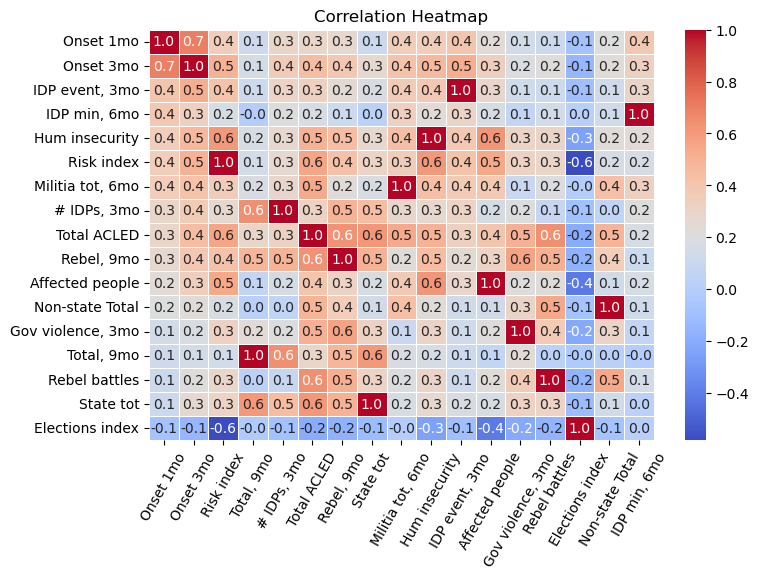

In [16]:
# Assuming 'clean_db' is your DataFrame and 'target' and 'cols' are defined elsewhere.
corr = clean_db[["onset_1000", "on_next3m_1000"] + cols].corr()
corr = corr.sort_values(by=target, ascending=False)

# Rename the columns and index using your dictionary.
corr_renamed = corr.rename(index=varname, columns=varname)

# Create a heatmap of the correlation matrix with the renamed features.
plt.figure(figsize=(8, 6))
sns.heatmap(corr_renamed, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.xticks(rotation=60)
#plt.savefig("./figures/corrmat_new.png")  # Uncomment to save the figure.
plt.show()


In [17]:
len(clean_db), len(raw_db)

(878, 12324)

In [18]:
scaler = MinMaxScaler()
train_db = clean_db[clean_db.yrmo< pd.Timestamp(year=2023, month=7, day=31)]
test_db = clean_db[clean_db.yrmo>= pd.Timestamp(year=2023, month=7, day=31)]

In [19]:
corrdb = train_db[[target,
 'ucdp_state_total',
 'ucdp_state_civ',
 'ucdp_nonstate_total',
 'ucdp_nonstate_civ',
 'ucdp_onesided_total',
 'ucdp_onesided_civ',
 'ucdp_total',
 'ucdp_civ',
 'acled_civ_protests',
 'acled_civ_remote',
 'acled_civ_riots',
 'acled_civ_strategic',
 'acled_civ_violence',
 'acled_ext_battles',
 'acled_ext_remote',
 'acled_ext_strategic',
 'acled_mil_battles',
 'acled_mil_protests',
 'acled_mil_remote',
 'acled_mil_riots',
 'acled_mil_strategic',
 'acled_mil_violence',
 'acled_reb_battles',
 'acled_reb_protests',
 'acled_reb_remote',
 'acled_reb_riots',
 'acled_reb_strategic',
 'acled_reb_violence',
 'acled_gov_battles',
 'acled_gov_protests',
 'acled_gov_remote',
 'acled_gov_riots',
 'acled_gov_strategic',
 'acled_gov_violence',
 'acled_civ_total',
 'acled_ext_total',
 'acled_mil_total',
 'acled_reb_total',
 'acled_gov_total',
 'acled_total',
 'inform_risk',
 'idps_count_nonzero_3',
 'idps_count_nonzero_6',
 'idps_count_nonzero_9',
 'idps_min_3',
 'idps_min_6',
 'idps_min_9',
 'idps_nonzero_once_9',
 'idps_nonzero_once_6',
 'idps_nonzero_once_3',
 'acled_reb_violence_3m_sum',
 'acled_reb_violence_6m_sum',
 'acled_reb_violence_9m_sum',
 'ucdp_total_3m_sum',
 'ucdp_total_6m_sum',
 'ucdp_total_9m_sum',
 'ucdp_nonstate_civ_3m_sum',
 'ucdp_nonstate_civ_6m_sum',
 'ucdp_nonstate_civ_9m_sum',
 'ucdp_nonstate_civ',
 'acled_gov_violence_3m_sum',
 'acled_gov_violence_6m_sum',
 'acled_gov_violence_9m_sum',
 'acled_mil_total_3m_sum',
 'acled_mil_total_6m_sum',
 'acled_mil_total_9m_sum',
 'idps_3m_sum',
 'idps_6m_sum',
 'idps_9m_sum',
 'cox_eth_frac',
 'vdem_elections.y',
 'cox_hum_insecurity',
 'imp_people_cat',
 'inform_sev']]

In [20]:
corrscaled = StandardScaler().fit_transform(corrdb.drop(columns=[target]))
df = pd.DataFrame(corrscaled, columns=corrdb.drop(columns=[target]).columns)

In [21]:
df

,ucdp_state_total,ucdp_state_civ,ucdp_nonstate_total,ucdp_nonstate_civ,ucdp_nonstate_civ,ucdp_onesided_total,ucdp_onesided_civ,ucdp_total,ucdp_civ,acled_civ_protests,...,acled_mil_total_6m_sum,acled_mil_total_9m_sum,idps_3m_sum,idps_6m_sum,idps_9m_sum,cox_eth_frac,vdem_elections.y,cox_hum_insecurity,imp_people_cat,inform_sev
0,0.696043,2.212747,-0.169658,-0.08246,-0.08246,3.996663,4.017868,1.693014,3.641036,-0.051917,...,2.071612,2.142322,2.925530,3.126010,2.109314,0.955264,-0.941378,1.806273,1.394229,1.947064
1,0.406917,0.578800,-0.169658,-0.08246,-0.08246,0.191451,0.196846,0.358401,0.301977,-0.051917,...,1.672672,2.038247,-0.102139,2.108378,1.960948,0.955264,-0.941378,1.806273,1.394229,1.947064
2,-0.026772,0.006918,-0.169658,-0.08246,-0.08246,0.134657,0.139816,-0.004086,0.106837,-0.051917,...,1.392335,1.788465,-0.195013,1.221088,1.877733,0.955264,-0.941378,1.806273,1.394229,1.947064
3,0.086813,-0.074779,-0.169658,-0.08246,-0.08246,0.219849,0.225361,0.111251,0.150202,-0.051917,...,0.675321,1.618475,-0.195013,0.511344,1.714079,0.955264,-1.233186,1.806273,1.394229,1.812709
4,-0.037098,-0.156477,-0.169658,-0.08246,-0.08246,-0.092520,-0.088305,-0.078231,-0.109985,-0.051917,...,0.772360,1.264618,-0.195013,-0.123308,1.131835,0.955264,-1.233186,1.806273,1.394229,1.812709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,-0.088728,-0.156477,-0.169658,-0.08246,-0.08246,-0.177711,-0.173850,-0.144138,-0.175031,-0.051917,...,3.446339,4.518717,0.702106,1.235946,1.301223,1.095045,-1.233186,0.047285,1.277566,1.275289
740,-0.181661,-0.156477,3.806959,-0.08246,-0.08246,-0.177711,-0.173850,0.292495,-0.175031,-0.051917,...,3.608072,3.339193,4.500215,2.103760,2.281162,1.095045,-1.233186,1.806273,1.277566,1.543999
741,-0.202313,-0.156477,-0.169658,-0.08246,-0.08246,-0.177711,-0.173850,-0.234760,-0.175031,-0.051917,...,2.238736,3.259402,1.194669,1.561036,1.894067,1.095045,-1.233186,1.806273,1.277566,1.543999
742,-0.202313,-0.156477,-0.169658,-0.08246,-0.08246,-0.177711,-0.173850,-0.234760,-0.175031,-0.051917,...,6.001715,4.213429,1.673078,1.207414,1.001348,1.095045,-1.233186,1.806273,1.160903,1.543999


In [22]:
df[target] = corrdb[target].values

In [23]:
correlation_matrix = df.corr()

# Get the correlation with the target and drop the target itself
correlations = correlation_matrix[target].drop(labels=[target])

In [24]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Calculate the correlation with the target
correlations = correlation_matrix[target].drop(labels=[target])

# Calculate mutual information
X = df.drop(columns=[target])
y = df[target]
mi_scores = mutual_info_classif(X, y, n_neighbors=5, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns)

# Combine correlation and mutual information scores
feature_scores = pd.DataFrame({
    'Correlation': correlations.abs(),
    'Mutual Information': mi_scores
})



In [25]:
correlation_matrix = df.corr()
correlations = correlation_matrix[target].drop(labels=[target]).abs()

# Calculate mutual information
X = df.drop(columns=[target])
y = df[target]
mi_scores = mutual_info_classif(X, y, n_neighbors=5, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns)

# Normalize the scores
scaler = MinMaxScaler()
correlations_normalized = pd.Series(scaler.fit_transform(correlations.values.reshape(-1, 1)).flatten(), index=correlations.index)
mi_scores_normalized = pd.Series(scaler.fit_transform(mi_scores.values.reshape(-1, 1)).flatten(), index=mi_scores.index)

# Define weights for each metric
weight_corr = 0.5
weight_mi = 0.5

# Combine the scores into a single metric
combined_scores = weight_corr * correlations_normalized + weight_mi * mi_scores_normalized

# Sort features based on the combined score
sorted_features = combined_scores.sort_values(ascending=False)

# Display the top features
print("Top features based on combined score:")
print(sorted_features.head(40))

Top features based on combined score:
acled_mil_total_6m_sum       0.837543
inform_risk                  0.832901
idps_min_6                   0.829784
idps_nonzero_once_3          0.820920
acled_mil_total_9m_sum       0.816604
idps_9m_sum                  0.816151
idps_nonzero_once_9          0.816146
acled_mil_total_3m_sum       0.808070
idps_6m_sum                  0.807378
idps_3m_sum                  0.781894
idps_nonzero_once_6          0.780859
cox_hum_insecurity           0.731092
idps_min_9                   0.730706
acled_mil_total              0.709236
idps_min_3                   0.697158
inform_sev                   0.664466
ucdp_total_9m_sum            0.660855
ucdp_total_6m_sum            0.627076
acled_total                  0.604790
acled_mil_violence           0.585872
acled_reb_violence_9m_sum    0.582089
imp_people_cat               0.554439
acled_gov_total              0.553500
ucdp_total_3m_sum            0.530744
acled_gov_violence_9m_sum    0.519194
cox_eth_frac

In [26]:
# Perform PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=[target]).values)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Get explained variance and loadings
explained_variance = pca.explained_variance_ratio_
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=df.columns.drop(target))

# Calculate correlation of each feature with each principal component
pca_correlations = pd.DataFrame(index=loadings_df.index)
for i in range(4):
    pca_correlations[f'PC{i+1}'] = df.drop(columns=[target]).corrwith(pd.Series(X_pca[:, i]))

# Calculate weighted mean correlation using explained variance as weights
pca_weights = explained_variance / explained_variance.sum()
pca_correlations['Weighted Mean PCA Corr'] = pca_correlations.dot(pca_weights)



In [27]:
# Combine correlation, mutual information, and weighted PCA correlation
feature_scores = pd.DataFrame({
    'Correlation': correlations,
    'Mutual Information': mi_scores,
    'Weighted Mean PCA Corr': np.abs(pca_correlations['Weighted Mean PCA Corr'])
})
feature_scores = feature_scores.dropna()

In [28]:
feature_scores = (feature_scores - feature_scores.min()) / (feature_scores.max() - feature_scores.min())

feature_scores = feature_scores.reset_index()
feature_scores.rename(columns={'index': 'Feature'}, inplace=True)
feature_scores['Average'] = feature_scores[['Correlation', 'Mutual Information', 'Weighted Mean PCA Corr']].mean(axis=1)

# Sort the DataFrame by the 'Average' column
feature_scores = feature_scores.sort_values(by='Average', ascending=False)

# Optionally, drop the 'Average' column if you no longer need it
feature_scores = feature_scores.drop(columns='Average')

In [29]:
len(feature_scores)

73

In [30]:
df_top20_normalized =  feature_scores.head(20)

In [31]:
df_top20_normalized = df_top20_normalized.head(20).set_index('Feature')

In [32]:
df_top20_normalized

,Correlation,Mutual Information,Weighted Mean PCA Corr
Feature,,,
idps_3m_sum,0.737754,0.826035,0.645243
idps_9m_sum,0.657019,0.975283,0.441633
acled_reb_violence_9m_sum,0.584459,0.579720,0.907201
ucdp_total_9m_sum,0.321711,1.000000,0.738062
idps_6m_sum,0.634340,0.980416,0.436197
inform_risk,0.766991,0.898810,0.371480
acled_total,0.618376,0.591204,0.799371
ucdp_total_6m_sum,0.322646,0.931506,0.729216
acled_mil_total_6m_sum,0.925800,0.749286,0.274886


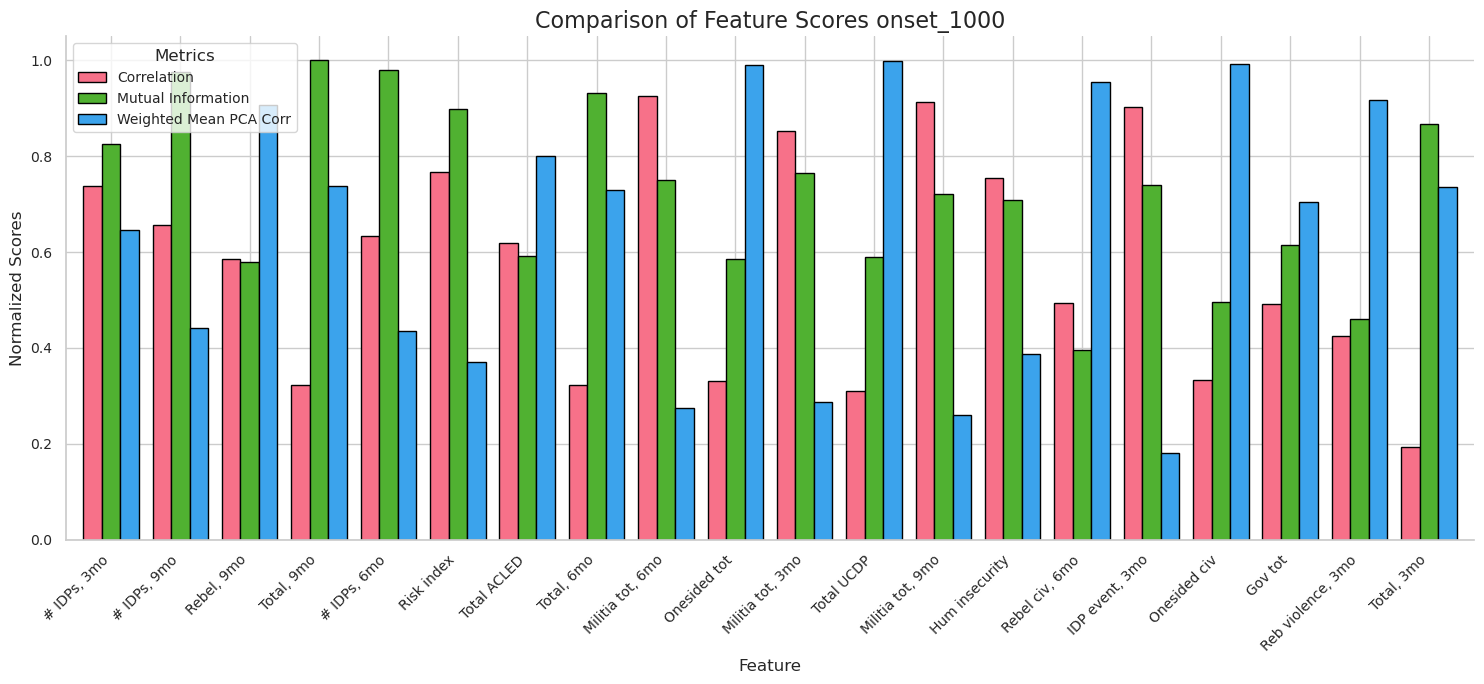

In [33]:
sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(df_top20_normalized.columns))

df_top20_normalized.rename(index=varname, inplace=True)
ax = df_top20_normalized.plot(kind='bar', figsize=(15, 7), width=0.8, color=palette, edgecolor='black')

# Add titles and labels
plt.title('Comparison of Feature Scores '+target, fontsize=16)
plt.ylabel('Normalized Scores', fontsize=12)
#plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Metrics', fontsize=10, title_fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

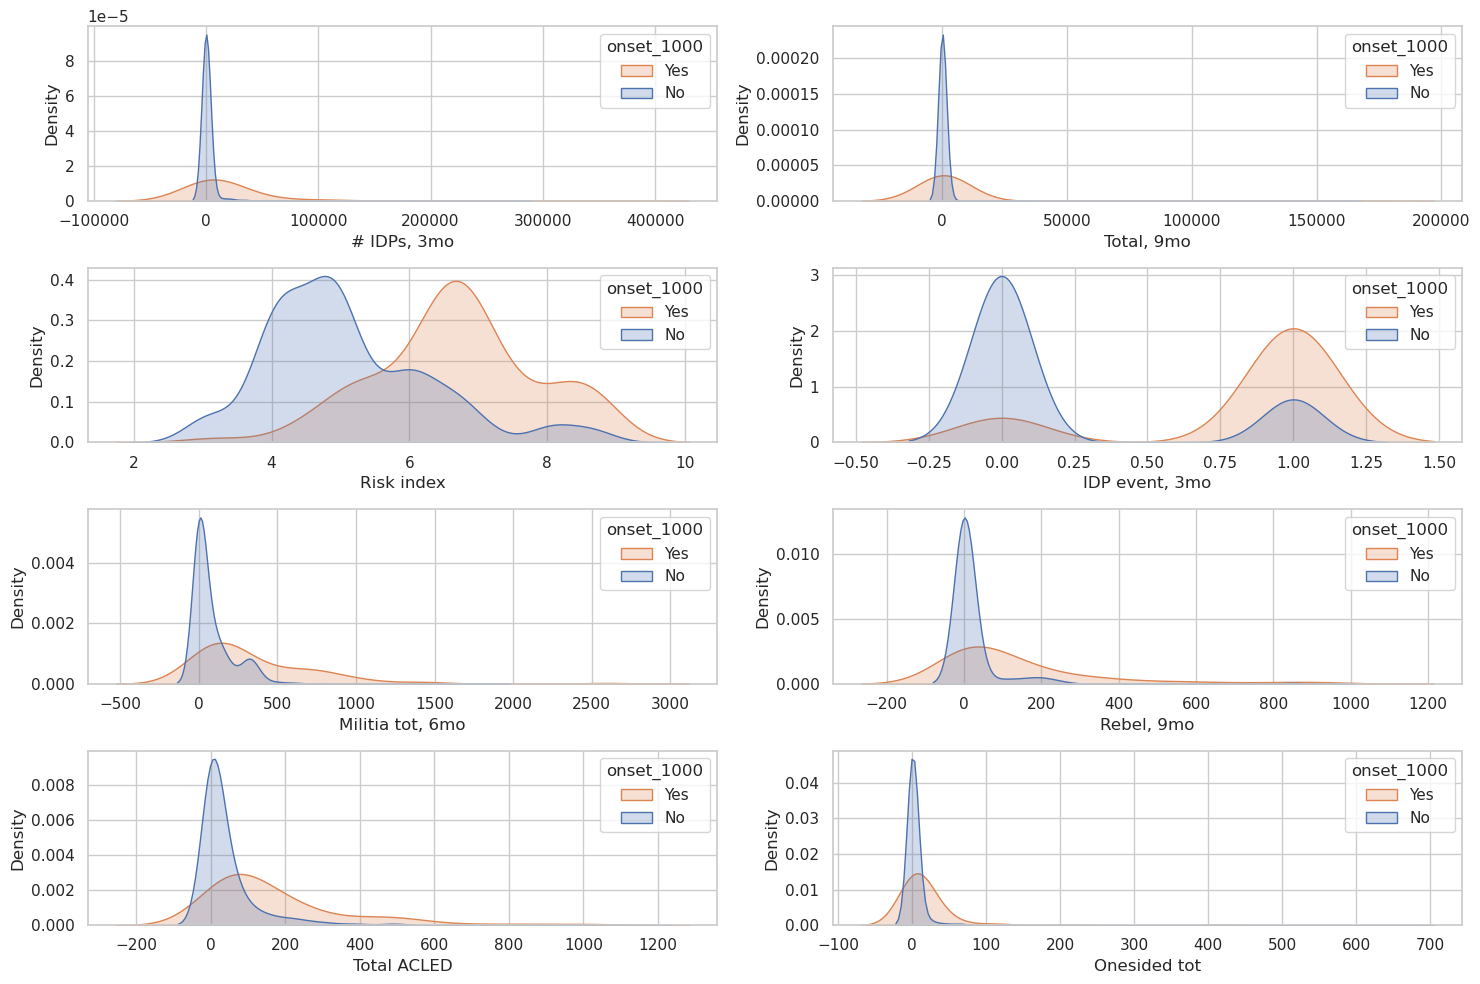

In [34]:
# Reverse the dictionary to map new names to old names
reversed_varname = {v: k for k, v in varname.items()}

# Create the figure and axes
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# List of new variable names
new_variables = ['# IDPs, 3mo', 'Total, 9mo', 'Risk index', 'IDP event, 3mo', 'Militia tot, 6mo', 'Rebel, 9mo', 'Total ACLED', 'Onesided tot' ]

# Loop through new variable names and create a KDE plot for each
for i, new_var in enumerate(new_variables):
    old_var = reversed_varname[new_var]  # Get the old variable name from the new one
    sns.kdeplot(data=clean_db, x=old_var, hue=target, common_norm=False, fill=True, ax=axes[i])
    axes[i].set_xlabel(new_var)  # Use new variable name for x-axis label
    axes[i].set_ylabel('Density')
    axes[i].legend(title=target, labels=['Yes', 'No'])

# Adjust the layout to prevent overlapping
plt.tight_layout()
#plt.savefig("./figures/density_plot3m.png")
plt.show()


In [35]:
len(train_db), len(test_db)

(744, 134)

In [36]:
y0 = test_db['idps_nonzero_once_6']

In [37]:
X_train = scaler.fit_transform(train_db[cols].values)
y_train = train_db[target]
X_test = scaler.transform(test_db[cols].values)
y_test = test_db[target]

In [38]:
y_test.value_counts()

0.0    117
1.0     17
Name: onset_1000, dtype: int64

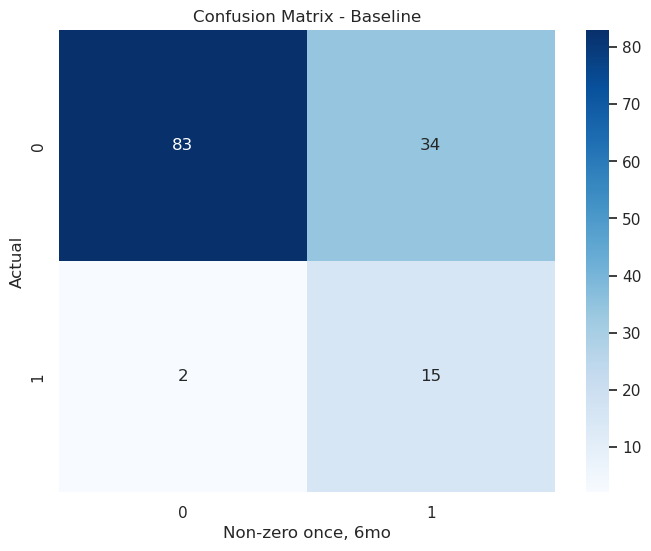

In [39]:
cm = confusion_matrix(y_test,y0)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline')
plt.xlabel('Non-zero once, 6mo')
plt.ylabel('Actual')
plt.show()

In [40]:
param_grid = {
    #'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [10, 20, 60],
    'min_samples_split': [6, 12, 24],
    'min_samples_leaf': [4, 22, 36],
    'max_depth': [3, 4, 5],
'class_weight': ['balanced']
}

# Initialize the model
rf = RandomForestClassifier(random_state=25)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='f1', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=12, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.1s
[CV] END class_weight=balanced, max_depth=3, min_samples_leaf=4, min_samples_spli

In [41]:
X_train = scaler.fit_transform(train_db[cols].values)
y_train = train_db[target]
X_test = scaler.transform(test_db[cols].values)
y_test = test_db[target]

In [42]:
rf = RandomForestClassifier(**best_params, random_state=25)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=4,
                       min_samples_split=6, n_estimators=20, random_state=25)

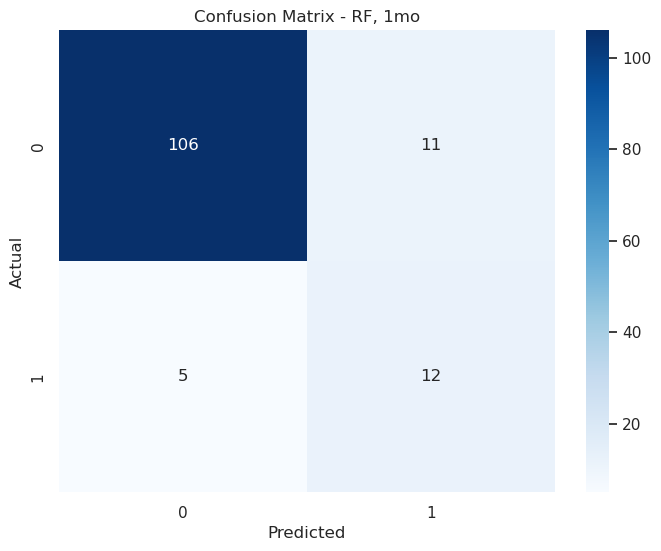

In [43]:
cm = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RF, 1mo')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
dt = DecisionTreeClassifier(max_depth = 3, min_samples_leaf=18, min_samples_split = 24, class_weight="balanced")
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=18, min_samples_split=24)

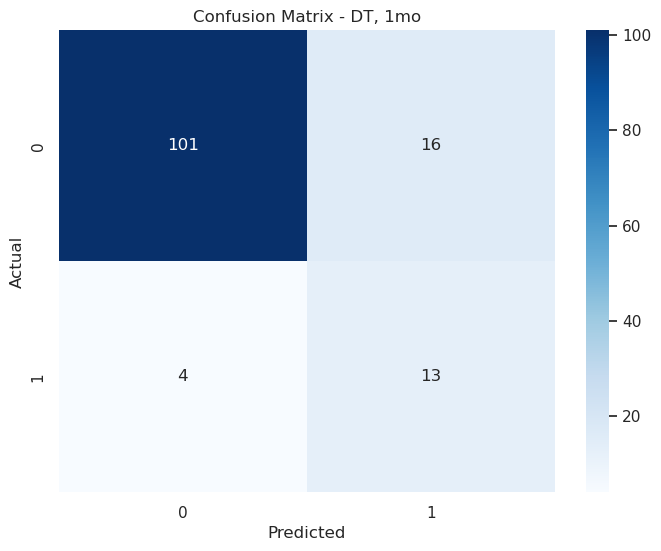

In [45]:
cm = confusion_matrix(y_test, dt.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - DT, 1mo')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
lr = LogisticRegression(penalty="l2", class_weight="balanced")
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

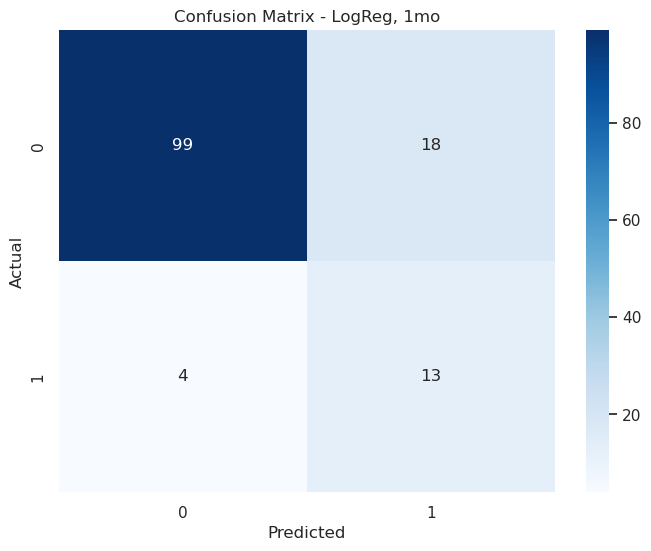

In [47]:
cm = confusion_matrix(y_test, lr.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LogReg, 1mo')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
gbm = GradientBoostingClassifier(**{'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 12, 'n_estimators': 20, 'n_iter_no_change': 12, "random_state":25 })
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, min_samples_leaf=8,
                           min_samples_split=12, n_estimators=20,
                           n_iter_no_change=12, random_state=25)

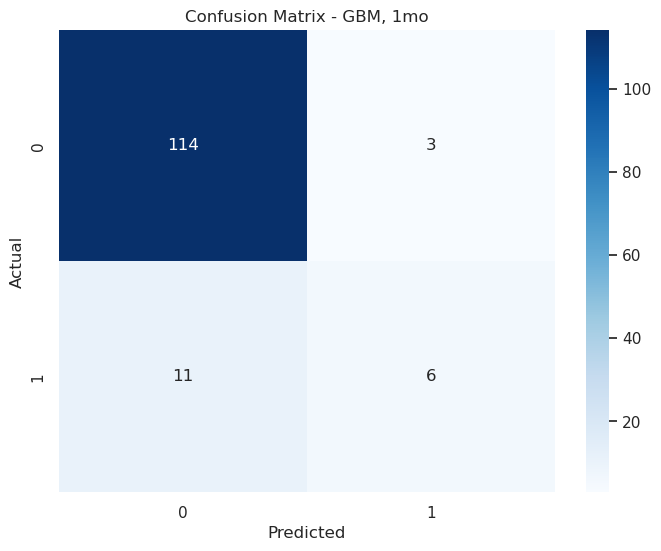

In [49]:
cm = confusion_matrix(y_test, gbm.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GBM, 1mo')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
accuracy_score(y_train, gbm.predict(X_train)), accuracy_score(y_test, gbm.predict(X_test)), f1_score(y_train, gbm.predict(X_train)), f1_score(y_test, gbm.predict(X_test)), jaccard_score(y_test, gbm.predict(X_test)),

(0.9717741935483871, 0.8955223880597015, 0.8, 0.46153846153846156, 0.3)

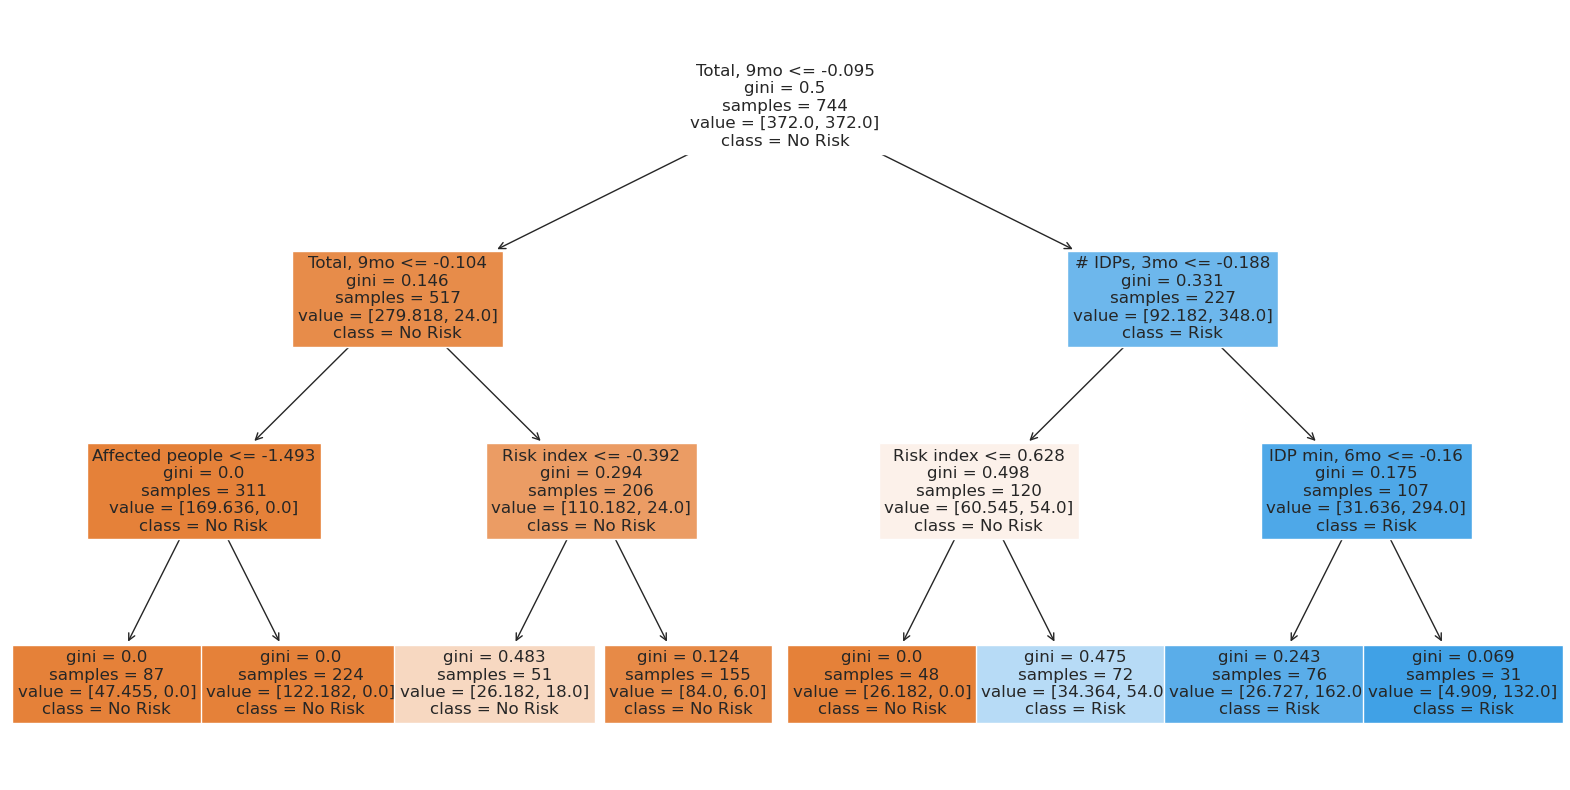

In [51]:
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=[varname[i] for i in cols], fontsize=12, class_names=['No Risk', 'Risk'], filled=True)
plt.show()

In [52]:
accuracy_score(y_train, rf.predict(X_train)), accuracy_score(y_test, rf.predict(X_test)), f1_score(y_train, rf.predict(X_train)), f1_score(y_test, rf.predict(X_test)), jaccard_score(y_test, rf.predict(X_test)),

(0.8763440860215054,
 0.8805970149253731,
 0.5533980582524272,
 0.6,
 0.42857142857142855)

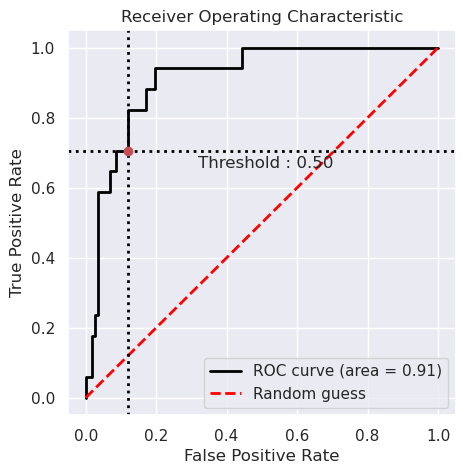

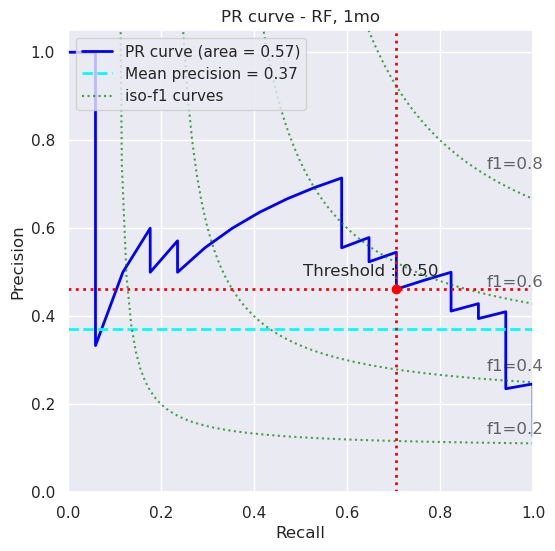

In [53]:
y_pred = rf.predict_proba(X_test)[:,1]
bc0 = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc0.plot_roc_curve()
plt.show()

param_pr_plot = {
    'c_pr_curve':'blue',
    'c_mean_prec':'cyan',
    'c_thresh_lines':'red',
    'c_f1_iso':'green',
    'beta': 1,
}

plt.figure(figsize=(6,6))
bc0.plot_precision_recall_curve(**param_pr_plot)
plt.title("PR curve - RF, 1mo")
plt.show()

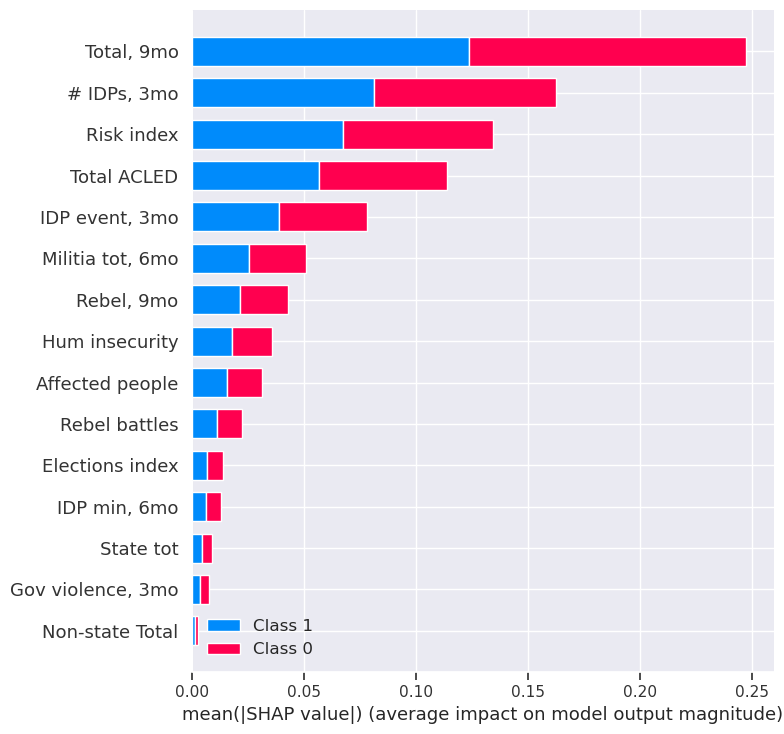

In [54]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train,show=False,  feature_names = [varname[i] for i in cols])


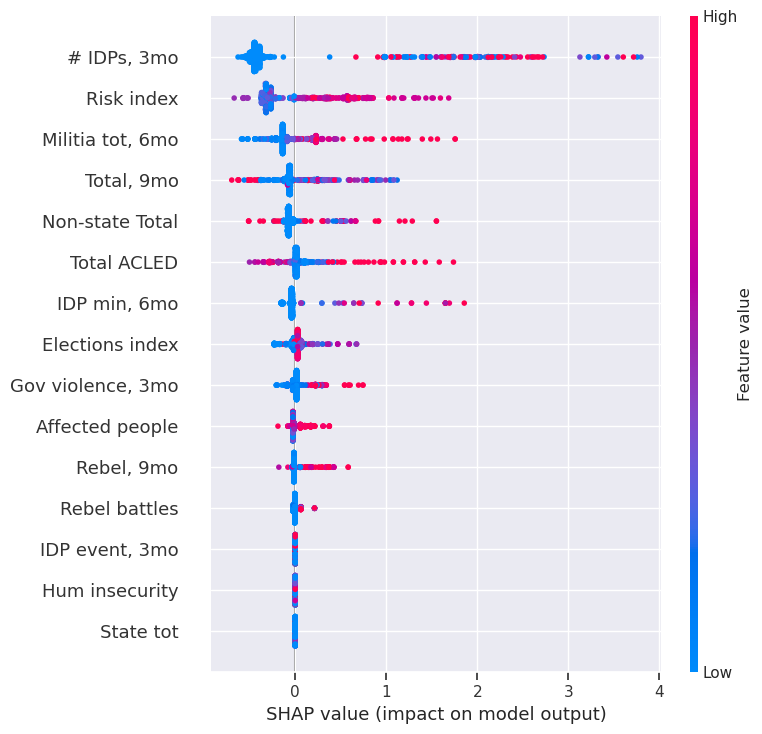

In [55]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train,show=False,  feature_names = [varname[i] for i in cols])


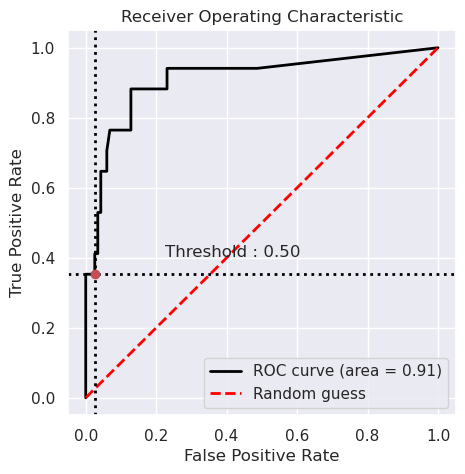

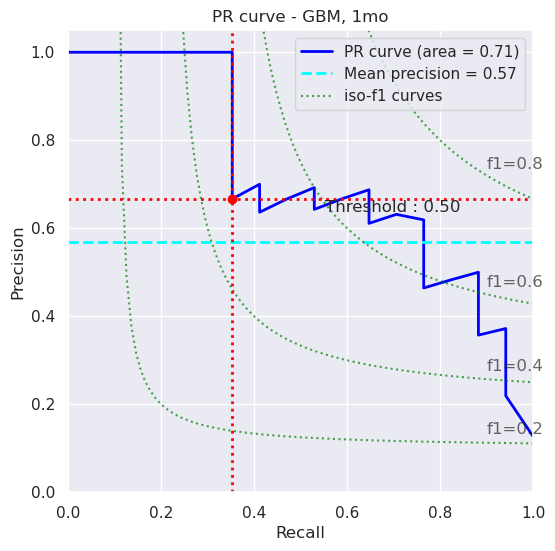

In [56]:
y_pred = gbm.predict_proba(X_test)[:,1]
bc0 = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc0.plot_roc_curve()
plt.show()

param_pr_plot = {
    'c_pr_curve':'blue',
    'c_mean_prec':'cyan',
    'c_thresh_lines':'red',
    'c_f1_iso':'green',
    'beta': 1,
}

plt.figure(figsize=(6,6))
bc0.plot_precision_recall_curve(**param_pr_plot)
plt.title("PR curve - GBM, 1mo")
plt.show()

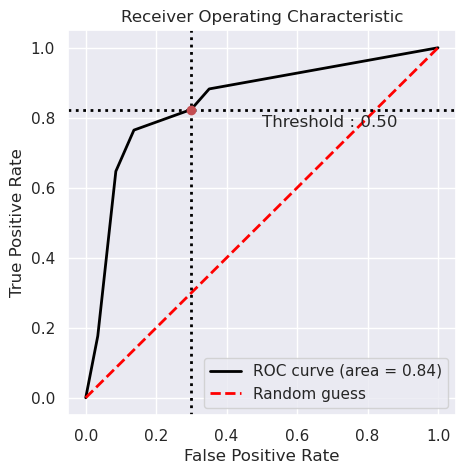

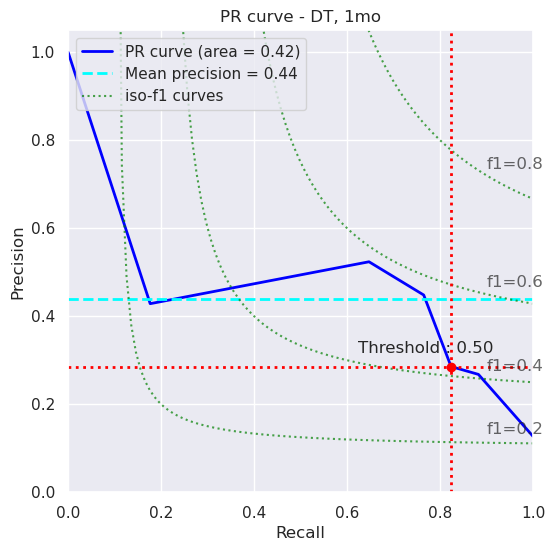

In [57]:
y_pred = dt.predict_proba(X_test)[:,1]
bc0 = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc0.plot_roc_curve()
plt.show()

param_pr_plot = {
    'c_pr_curve':'blue',
    'c_mean_prec':'cyan',
    'c_thresh_lines':'red',
    'c_f1_iso':'green',
    'beta': 1,
}

plt.figure(figsize=(6,6))
bc0.plot_precision_recall_curve(**param_pr_plot)
plt.title("PR curve - DT, 1mo")
plt.show()

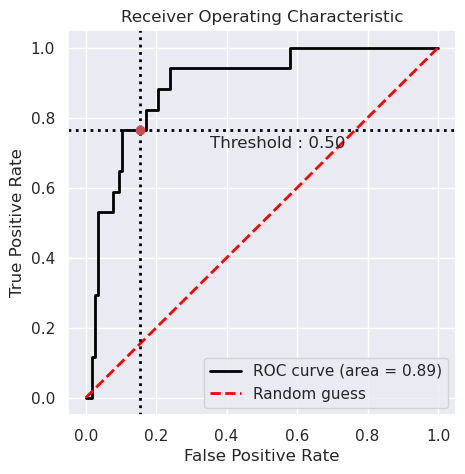

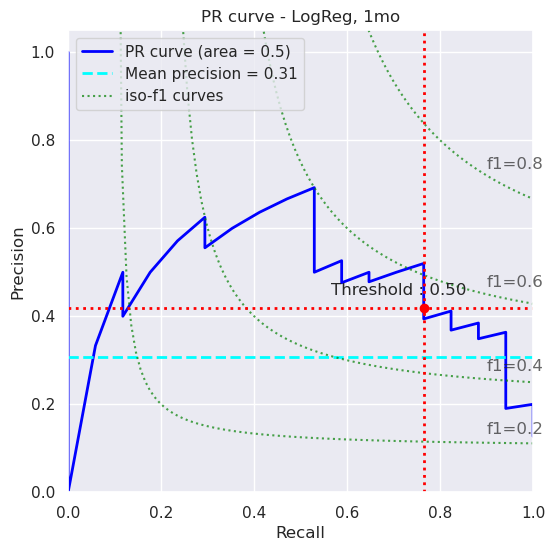

In [58]:
y_pred = lr.predict_proba(X_test)[:,1]
bc0 = BinaryClassification(y_test, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc0.plot_roc_curve()
plt.show()

param_pr_plot = {
    'c_pr_curve':'blue',
    'c_mean_prec':'cyan',
    'c_thresh_lines':'red',
    'c_f1_iso':'green',
    'beta': 1,
}

plt.figure(figsize=(6,6))
bc0.plot_precision_recall_curve(**param_pr_plot)
plt.title("PR curve - LogReg, 1mo")
plt.show()

In [59]:
metrics_history = []

# Iterate over the number of events to add to the train_db each time
for i in range(len(test_db) - 1):
    # Incrementally add one more event to the training set
    current_train_db = pd.concat([train_db, test_db.iloc[:i+1]])
    current_test_db = test_db.iloc[i+1:]
    #print(len(current_train_db), len(current_test_db))


    # Scale the data
    X_train = scaler.fit_transform(current_train_db[cols].values)
    y_train = current_train_db[target]
    X_test = scaler.transform(current_test_db[cols].values)
    y_test = current_test_db[target]

    # Train the model
    rf =  DecisionTreeClassifier(max_depth = 3, min_samples_leaf=18, min_samples_split = 12, class_weight="balanced")
    rf.fit(X_train, y_train)

    # Compute predictions
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    # Compute metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_jaccard = jaccard_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    print("F1 = ", test_f1)

    # Store the metrics in a dictionary
    metrics = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'test_jaccard': test_jaccard,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_size': len(current_train_db),
        'test_size': len(current_test_db)
    }

    # Append to the list
    metrics_history.append(metrics)

# Convert metrics_history to a DataFrame for easier analysis
metrics_df_rf = pd.DataFrame(metrics_history)

F1 =  0.5777777777777777
F1 =  0.5909090909090909
F1 =  0.6046511627906976
F1 =  0.6190476190476191
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.6341463414634146
F1 =  0.65
F1 =  0.6666666666666667
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6842105263157896
F1 =  0.6470588235294117
F1 =  0.6666666666666666
F1 =  0.6451612903225806
F1 =  0.6206896551724138
F1 =  0.5925925925925926
F1 =  0.5925925925925926
F1 =  0.5925925925925926
F1 =  0.5925925925925926
F1 =  0.5925925925925926
F1 =  0.5925925925925926
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56
F1 =  0.56

In [60]:
results = {}

# Calculate the mean and standard deviation for each metric
for metric in metrics_df_rf.columns:
    mean_value = metrics_df_rf[metric].mean()
    std_dev = metrics_df_rf[metric].std()
    n = len(metrics_df_rf[metric])  # Number of observations
    sem = std_dev / np.sqrt(n)  # Standard error of the mean

    # 95% CI for a Gaussian distribution
    ci_range = norm.ppf(0.975) * sem  # 0.975 corresponds to the 97.5th percentile

    # Store the results
    results[metric] = {
        'mean': mean_value,
        '95% CI lower': mean_value - ci_range,
        '95% CI upper': mean_value + ci_range
    }

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T
results_df

,mean,95% CI lower,95% CI upper
train_accuracy,0.879016,0.874496,0.883535
test_accuracy,0.844050,0.828152,0.859949
train_f1,0.558860,0.551130,0.566590
test_f1,0.583802,0.562234,0.605369
test_jaccard,0.423315,0.401885,0.444745
train_precision,0.412875,0.404206,0.421543
test_precision,0.560186,0.525632,0.594740
train_recall,0.878505,0.874057,0.882953
test_recall,0.644621,0.622884,0.666358
train_size,811.000000,804.450474,817.549526
